# Using xray to analyze Pacific SST Variability #

This lesson introduces the powerful [xray](http://xray.readthedocs.org) package for analyzing multidimensional netCDF data.

We will use xray to perform standard climatological analysis of tropical pacific sea surface temperature, looking for the signature of the [El Niño / Southern Oscillation (ENSO)](http://iri.columbia.edu/our-expertise/climate/enso/) phenomenon.

In [1]:
# import necessary modules
import xray
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
# the data we will use is described here
# http://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v4
# It is stored in the IRI data library
uri = ('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/'
      '.version4/anom/.sst/T/(days%20since%201960-01-01)/streamgridunitconvert/dods')

# open xray dataset
ds = xray.open_dataset(uri)
ds

<xray.Dataset>
Dimensions:  (T: 1939, X: 180, Y: 89, zlev: 1)
Coordinates:
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * zlev     (zlev) float32 0.0
  * Y        (Y) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * T        (T) datetime64[ns] 1854-01-16T12:00:00 1854-02-15 ...
Data variables:
    sst      (T, zlev, Y, X) float64 ...
Attributes:
    Conventions: IRIDL

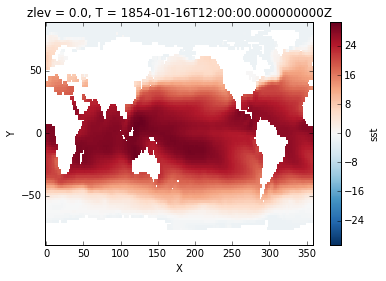

In [3]:
# make an exploratory plot
xray.plot.pcolormesh(ds['sst'][0,0])

## Niño3.4 Index ##

The [Niño3.4 Index](http://www.cgd.ucar.edu/cas/catalog/climind/TNI_N34/index.html#Sec5) is a commonly used metric of ENSO variability. The recipe for calculating it is

* Compute area averaged total SST from Niño 3.4 region.
* Compute monthly climatology (1950-1979) for area averaged total SST from Niño 3.4 region, and subtract climatology from area averaged total SST time series to obtain anomalies.
* Smooth the anomalies with a 5-month running mean.
* Normalize the smoothed N3.4 by its standard deviation over the climatological period 1950-1979.


In [22]:
# The Niño 3.4 Region is bounded by 120°W-170°W and 5°S- 5°N.
# extract this region
sst_n34 = ds.sst.sel(X=slice(190,240), Y=slice(-5,5), zlev=0).mean(dim=('X','Y'))

In [23]:
# calculate monthly anomaly
sst_n34_clim = sst_n34.groupby('T.month').mean('T')
sst_n34_anom = sst_n34.groupby('T.month') - sst_n34_clim

In [30]:
# "smooth with 5-month running mean"
# The closest thing we can do with xray is resample to 5-month intervals,
# which effectively accomplishes the same thing
sst_n34_smooth = sst_n34_anom.resample('5M', 'T')

In [32]:
# now normalize by standard deviation
n34_index = sst_n34_smooth / sst_n34_smooth.sel(T=slice('1950','1979')).std()

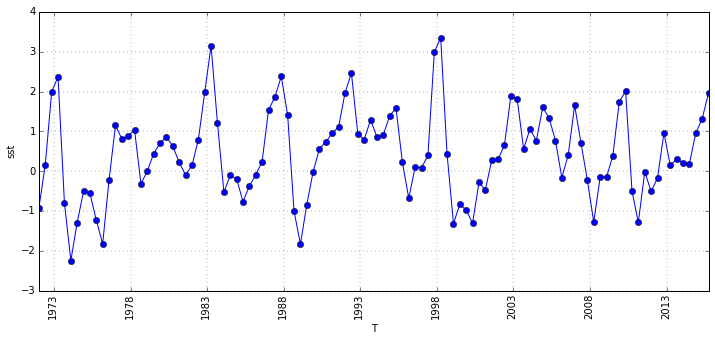

In [42]:
# plot it
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
xray.plot.plot(n34_index, ax=ax, marker='o')
ax.set_xlim(['1972-01,01','2015-10-01'])
ax.grid()

## PCA Analysis of Tropical Pacific SST ##

Now we use a singular value decomposition to perform a [principal component analysis](http://iridl.ldeo.columbia.edu/dochelp/StatTutorial/SVD/) on the 2D sst fields.

In [43]:
# extract a region in space and time
sst_pac = ds.sst.sel(X=slice(120,300), Y=slice(-30,30),
                     T=slice('1950-01-1','2015-10-01'), zlev=0)

In [44]:
# we will NOT subtract a monthly climatology
# we want to see the seasonal cycle emerge from our analysis
# instead just subtract the time mean
ssta_pac = sst_pac - sst_pac.mean(dim='T')

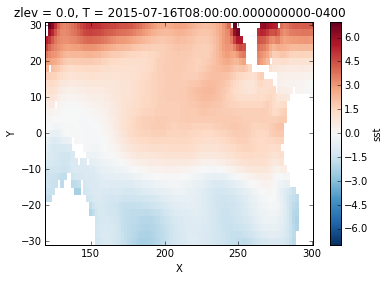

In [48]:
# visualize the region we're working with
ssta_pac[-1].plot.pcolormesh()

In [50]:
# exract the raw data as numpy array and normalize
a = np.ma.masked_invalid(ssta_pac.values.copy()).filled(0.)
a -= a.mean()
a /= a.std()
print(a.mean(), a.std())

-1.84986580168e-17 1.0


In [51]:
# reshape the array to have one time dimension, one space dimension
Nt, Ny, Nx = a.shape
a.shape = (Nt, Ny*Nx)

In [53]:
# perform svd analysis
u, s, v = np.linalg.svd(a, full_matrices=False)
print(u.shape, v.shape, s.shape)
S = np.diag(s)

# reshape spatial pattern
sst_pat = np.reshape(v, (Nt,Ny,Nx))

(787, 787) (787, 2821) (787,)


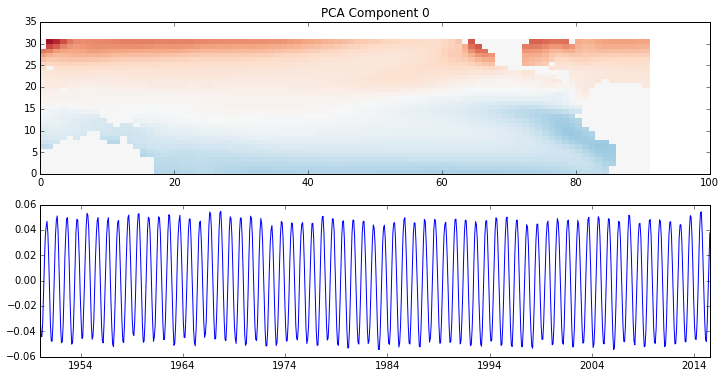

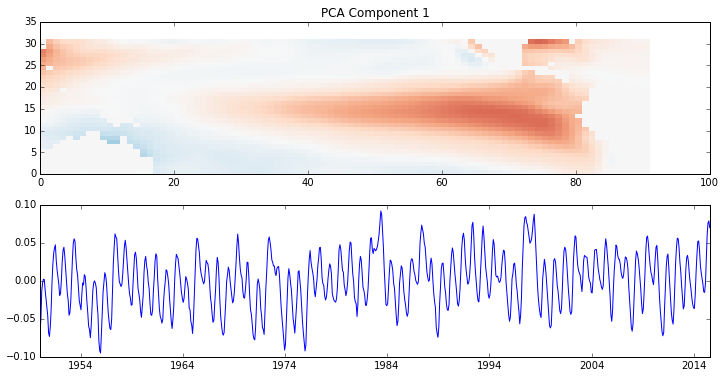

In [60]:
# look at first two eof patterns
for n in range(2):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    plt.pcolormesh(sst_pat[n], cmap='RdBu_r')
    plt.title('PCA Component %g' % n)
    plt.clim([-0.1,0.1])
    plt.subplot(212)
    plt.plot(sst_pac['T'], u[:,n])
    

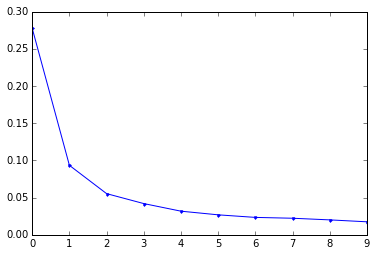

In [61]:
# magnitude of first 10 components
plt.plot(s[:10] / s.sum(),'.-')